In [2]:
import sys
sys.path.append("../detectron2")

In [3]:
import cv2
import io
import numpy as np
from  matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display
import PIL.Image
import torch
import os


from detectron2.modeling import build_backbone
from detectron2.modeling.poolers import ROIPooler
from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [5]:
confidence_threshold = 0.5
config_file = "../detectron2/configs/COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"
model_weights = "../detectron2/demo/faster_rcnn_R_101_C4_3x.pkl"

In [6]:
cfg = get_cfg()
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS =model_weights
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = confidence_threshold
cfg.freeze()
backbone = build_backbone(cfg)
predictor = DefaultPredictor(cfg)

### 将输入的视频提取成帧的形式保存到tmp（临时文件）文件夹下

In [32]:
videopath = "./TrainValsegment/video0/video1.mp4"

In [33]:
video=cv2.VideoCapture(videopath)
c=0
if video.isOpened():
    rval,frame=video.read()
else:
    rval=False
outputpath = "./tmp1"
if not os.path.exists(outputpath):
    os.makedirs(outputpath)
#隔一帧取一张图片
while rval:
    rval,frame=video.read()
    if rval:
        if c%2==0:
            cv2.imwrite(outputpath+'/'+str(c//2)+'.jpg',frame)
        c=c+1
        cv2.waitKey(1)
video.release()

### 从第一帧中提取被检测出的bounding box

In [32]:
im1path = "./tmp/0.jpg" 

Instances(num_instances=4, image_height=240, image_width=320, fields=[pred_boxes: Boxes(tensor([[ 23.4511,   7.2789, 309.8318, 238.9635],
        [ 26.1194,  12.6935, 163.2621, 231.0703],
        [  3.8050,  25.7060,  75.9872, 235.6143],
        [ 39.6411, 128.6855, 277.9942, 238.7505]])), scores: tensor([0.9900, 0.9241, 0.6614, 0.5661]), pred_classes: tensor([ 0,  0, 56,  0])])


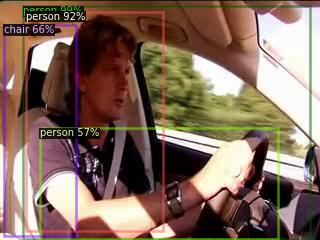

In [33]:
im = cv2.imread(im1path)
pred1 = predictor(im)
#MetadataCatalog.get("vg").thing_classes = []
v = Visualizer(im[:, :, :],MetadataCatalog.get("coco_2017_train"))
pred = pred1['instances'].to('cpu')
print(pred)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])

### 从第二帧中提取被检测出的bounding box

Instances(num_instances=5, image_height=240, image_width=320, fields=[pred_boxes: Boxes(tensor([[ 17.3808,   6.1478, 303.0605, 240.0000],
        [165.3070, 178.7682, 182.3537, 197.3901],
        [ 45.9925, 123.5699, 295.0888, 240.0000],
        [137.4300,  37.3525, 280.8082, 188.7440],
        [  3.3860,  30.3622,  73.9963, 239.9579]])), scores: tensor([0.9872, 0.7682, 0.6444, 0.5702, 0.5332]), pred_classes: tensor([ 0, 74,  0, 67, 56])])


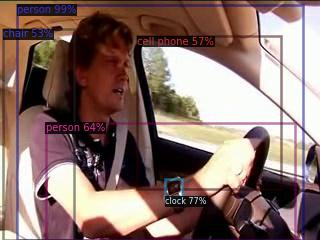

In [16]:
im2path = "./tmp/9.jpg" 
im = cv2.imread(im2path)
pred2 = predictor(im)
#MetadataCatalog.get("vg").thing_classes = []
v = Visualizer(im[:, :, :],MetadataCatalog.get("coco_2017_train"))
output = pred2['instances']
pred = pred2['instances'].to('cpu')
print(pred)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])

In [43]:
MetadataCatalog.get("coco_2017_train").thing_classes[56]

'chair'

### 提取res4特征

In [61]:
raw_boxes = output.pred_boxes

In [63]:
from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image

raw_height, raw_width = im.shape[:2]
print("Original image size: ", (raw_height, raw_width))
image = predictor.transform_gen.get_transform(im).apply_image(im)
print("Transformed image size: ", image.shape[:2])
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
print("the lenth of tensor: ",image.shape)
inputs = [{"image": image, "height": raw_height, "width": raw_width}]
images = predictor.model.preprocess_image(inputs)
features = predictor.model.backbone(images.tensor)
print("the size of feature: ",features['res4'].shape)
new_height, new_width = image.shape[:2]
scale_x = 1. * new_width / raw_width
scale_y = 1. * new_height / raw_height
#print(scale_x, scale_y) 
boxes = raw_boxes.clone()
boxes.scale(scale_x=scale_x, scale_y=scale_y)
proposal_boxes = [boxes]
nfeatures = [features[f] for f in predictor.model.roi_heads.in_features]
box_features = predictor.model.roi_heads._shared_roi_transform(nfeatures, proposal_boxes)
feature_pooled = box_features.mean(dim=[2, 3])
print("the final shape of feature: ",feature_pooled.shape)

Original image size:  (240, 320)
Transformed image size:  (800, 1067)
the lenth of tensor:  torch.Size([3, 800, 1067])
the size of feature:  torch.Size([1, 1024, 50, 67])
the final shape of feature:  torch.Size([4, 2048])


In [67]:
feature_pooled = feature_pooled.to('cpu')
print(feature_pooled[0])

tensor([0.0000, 0.0000, 0.0199,  ..., 0.1083, 0.0206, 0.1276],
       grad_fn=<SelectBackward>)


### 提取直方图特征

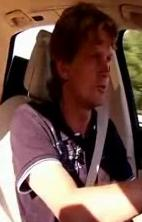

In [74]:
im1 = cv2.imread(im1path)
im2 = cv2.imread(im2path)
part1 = im2[13:231,26:163,:]
part2 = im2[11:233,18:160,:]
showarray(part[:, :, ::-1])

In [78]:
histB1 = cv2.calcHist([part1], [0], None, [32], [0, 256])
histG1 = cv2.calcHist([part1], [1], None, [32], [0, 256])
histR1 = cv2.calcHist([part1], [2], None, [32], [0, 256])
histB2 = cv2.calcHist([part2], [0], None, [32], [0, 256])
histG2 = cv2.calcHist([part2], [1], None, [32], [0, 256])
histR2 = cv2.calcHist([part2], [2], None, [32], [0, 256])

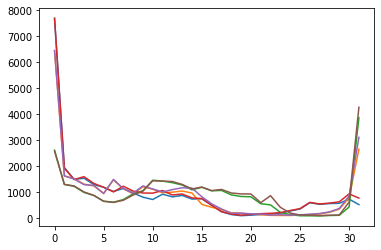

In [79]:
plt.plot(histB1)
plt.plot(histG1)
plt.plot(histR1)
plt.plot(histB2)
plt.plot(histG2)
plt.plot(histR2)

In [83]:
print("蓝色相关性为：",cv2.compareHist(histB1, histB2, method=cv2.HISTCMP_CORREL))
print("绿色相关性为：",cv2.compareHist(histG1, histG2, method=cv2.HISTCMP_CORREL))
print("红色相关性为：",cv2.compareHist(histR1, histR2, method=cv2.HISTCMP_CORREL))

蓝色相关性为： 0.9985067203715052
绿色相关性为： 0.9966813500710914
红色相关性为： 0.9923835428530359


### 计算面积

In [84]:
def caulateArea(bbx):
    """
    计算矩形面积
    """
    return (bbx[2]-bbx[0])*(bbx[3]-bbx[1])

In [87]:
area1 = caulateArea([ 18.4614,  10.8014, 160.3646, 232.5071])
area2 = caulateArea([ 26.1194,  12.6935, 163.2621, 231.0703])
print(area2/area1)

0.9519412473909538


### 计算IOU

In [88]:
def IOU(Reframe,GTframe):
    """
    计算两矩形 IOU，传入为均为矩形对角线，（x,y）  坐标。输出为计算得到的IOU值
    """
    x1 = Reframe[0]
    y1 = Reframe[1]
    width1 = Reframe[2]-Reframe[0]
    height1 = Reframe[3]-Reframe[1]

    x2 = GTframe[0]
    y2 = GTframe[1]
    width2 = GTframe[2]-GTframe[0]
    height2 = GTframe[3]-GTframe[1]

    endx = max(x1+width1,x2+width2)
    startx = min(x1,x2)
    width = width1+width2-(endx-startx)

    endy = max(y1+height1,y2+height2)
    starty = min(y1,y2)
    height = height1+height2-(endy-starty)

    if width <=0 or height <= 0:
        ratio = 0 # 重叠率为 0 
    else:
        Area = width*height # 两矩形相交面积
        Area1 = width1*height1
        Area2 = width2*height2
        ratio = Area*1./(Area1+Area2-Area)
    # return IOU
    return ratio

In [89]:
IOU([ 18.4614,  10.8014, 160.3646, 232.5071],[ 26.1194,  12.6935, 163.2621, 231.0703])

0.9134572950329208

In [99]:
tstbox = output.pred_boxes.to("cpu")
tstbox.tensor.numpy()

array([[ 15.560842,   5.264786, 298.73416 , 238.8623  ],
       [ 18.461407,  10.801447, 160.3646  , 232.50706 ],
       [ 40.590504,   2.302977, 303.26273 , 128.97305 ],
       [  2.629017,  30.339212,  78.94222 , 236.18282 ]], dtype=float32)

### 抽取带有bbxs的视频

In [18]:
from glob import glob

In [35]:
paths = sorted(glob('tmp1/*.jpg'),key = lambda x: int(x[5:-4]))
paths

['tmp1/0.jpg',
 'tmp1/1.jpg',
 'tmp1/2.jpg',
 'tmp1/3.jpg',
 'tmp1/4.jpg',
 'tmp1/5.jpg',
 'tmp1/6.jpg',
 'tmp1/7.jpg',
 'tmp1/8.jpg',
 'tmp1/9.jpg',
 'tmp1/10.jpg',
 'tmp1/11.jpg',
 'tmp1/12.jpg',
 'tmp1/13.jpg',
 'tmp1/14.jpg',
 'tmp1/15.jpg',
 'tmp1/16.jpg',
 'tmp1/17.jpg',
 'tmp1/18.jpg',
 'tmp1/19.jpg',
 'tmp1/20.jpg',
 'tmp1/21.jpg',
 'tmp1/22.jpg',
 'tmp1/23.jpg',
 'tmp1/24.jpg',
 'tmp1/25.jpg',
 'tmp1/26.jpg',
 'tmp1/27.jpg',
 'tmp1/28.jpg',
 'tmp1/29.jpg',
 'tmp1/30.jpg',
 'tmp1/31.jpg',
 'tmp1/32.jpg',
 'tmp1/33.jpg',
 'tmp1/34.jpg',
 'tmp1/35.jpg',
 'tmp1/36.jpg',
 'tmp1/37.jpg',
 'tmp1/38.jpg',
 'tmp1/39.jpg',
 'tmp1/40.jpg',
 'tmp1/41.jpg',
 'tmp1/42.jpg',
 'tmp1/43.jpg',
 'tmp1/44.jpg',
 'tmp1/45.jpg',
 'tmp1/46.jpg',
 'tmp1/47.jpg',
 'tmp1/48.jpg',
 'tmp1/49.jpg',
 'tmp1/50.jpg',
 'tmp1/51.jpg',
 'tmp1/52.jpg',
 'tmp1/53.jpg',
 'tmp1/54.jpg',
 'tmp1/55.jpg',
 'tmp1/56.jpg',
 'tmp1/57.jpg',
 'tmp1/58.jpg',
 'tmp1/59.jpg',
 'tmp1/60.jpg']

In [36]:
trackoutputpath = "./trackpic1"
if not os.path.exists(trackoutputpath):
    os.makedirs(trackoutputpath)

In [37]:
for i, path in enumerate(paths):
    im = cv2.imread(path)
    
    pred2 = predictor(im)
    #MetadataCatalog.get("vg").thing_classes = []
    v = Visualizer(im[:, :, :],MetadataCatalog.get("coco_2017_train"))
    pred = pred2['instances'].to('cpu')
    v = v.draw_instance_predictions(pred)
    cv2.imwrite(trackoutputpath+'/'+str(i)+'.jpg',v.get_image())